In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, time

In [2]:
os.makedirs(os.path.join('new','figures'),exist_ok=True)
os.makedirs(os.path.join('new','data'), exist_ok=True)

In [3]:
default_values = {
    'g1': 0.2,
    'g2': 0.1,
    'g3': 0.0,
    'alpha_1': 1e-2,
    'alpha_2': 1e-4,
    'lambda_1': 1e-2,
    'lambda_2': 1e-4,
    'lambda_r': .08,
    'beta': 1e-4,
}

def s21_theoretical(
    w, H,
    g1=default_values['g1'],
    g2=default_values['g2'],
    g3=default_values['g3'],
    alpha_1=default_values['alpha_1'],
    alpha_2=default_values['alpha_2'],
    lambda_1=default_values['lambda_1'],
    lambda_2=default_values['lambda_2'],
    lambda_r=default_values['lambda_r'],
    beta=default_values['beta']
):
    
    matrices = []

    for i in range(3):
        for j in range(3):
            mat = np.zeros((3, 3), dtype=int)
            mat[i, j] = 1
            matrices.append(mat)
    
    # Constants
    gyro1 = 2.94e-3
    gyro2 = 1.76e-2 / (2 * np.pi)
    M1 = 10900.0  # Py
    M2 = 1750.0   # YIG

    gamma_1 = 2 * np.pi * lambda_1**2
    gamma_2 = 2 * np.pi * lambda_2**2
    gamma_r = 2 * np.pi * lambda_r**2

    alpha_r = beta

    omega_1 = gyro1 * np.sqrt(H * (H + M1))
    omega_2 = gyro2 * np.sqrt(H * (H + M2))
    omega_r = 5.0 # Assuming this was a constant, in Julia it's 5

    tomega_1 = omega_1 - 1j * (alpha_1 + gamma_1)
    tomega_2 = omega_2 - 1j * (alpha_2 + gamma_2)
    tomega_r = omega_r - 1j * (alpha_r + gamma_r)

    # Construct the matrix M
    M = np.array([
        [w - tomega_1,                             -g1 + 1j * np.sqrt(gamma_1 * gamma_r), -g3 + 1j * np.sqrt(gamma_1 * gamma_2)],
        [-g1 + 1j * np.sqrt(gamma_1 * gamma_r),    w - tomega_r,                          -g2 + 1j * np.sqrt(gamma_2 * gamma_r)],
        [-g3 + 1j * np.sqrt(gamma_1 * gamma_2),    -g2 + 1j * np.sqrt(gamma_2 * gamma_r),   w - tomega_2]
    ], dtype=complex)

    B = np.array([np.sqrt(gamma_1), np.sqrt(gamma_r), np.sqrt(gamma_2)], dtype=complex)

    try:
        inv_M = np.linalg.inv(M)
        B_row_real = np.array([np.sqrt(gamma_1), np.sqrt(gamma_r), np.sqrt(gamma_2)]) 
        result = B_row_real @ inv_M @ B_row_real
    except np.linalg.LinAlgError:
        print(f"Singular matrix for w={w}, H={H}. Returning NaN.")
        return np.nan

    return np.abs(result)

def coupling(grid_resolution=100,plot=False,**parameters):
    
    def analyze_array(arr, slope, name):
        # Length
        length = len(arr)
        # Number of zeros at the end
        num_zeros_end = 0
        largest_indices = None
        for val in arr[::-1]:
            if val == 0:
                num_zeros_end += 1
            else:
                break
        # Largest two elements
        if np.count_nonzero(arr) >= 2:
            largest_indices = np.argpartition(arr, -2)[-2:]
            largest_values = arr[largest_indices]
            largest_values = np.sort(largest_values)[::-1]
        else:
            largest_values = arr[np.nonzero(arr)]
        # print(f"{name}:")
        # print(f"  Length: {length}")
        # print(f"  Number of zeros at the end: {num_zeros_end}")
        # print(f"  Largest two elements: {largest_values}")
        # print(f"  Difference between largest two elements: {np.diff(largest_values).__abs__()}")
        coupling = np.diff(omega[largest_indices]).__abs__()[0]/np.sin(-np.arctan(slope))
        # print(f"  Coupling gap: {coupling:.5f}\n")

        return coupling, largest_indices

    omega = np.linspace(4.3,6.1, grid_resolution)  # Example frequency range
    # omega = np.linspace(0,10, grid_resolution)  # Example frequency range
    H = np.linspace(0, 1600, grid_resolution)  # Example magnetic field range

    s21 = np.zeros((omega.size, H.size))

    for i, w in enumerate(omega):
        for j, h in enumerate(H):
            s21[i,j] = s21_theoretical(w,h,**parameters)

    line_a = [(238,5.063),(290,4.917)]
    line_b = [(1093,5.076),(1137,4.931)]

    slope_a, intercept_a = np.polyfit(*zip(*line_a), 1)
    slope_b, intercept_b = np.polyfit(*zip(*line_b), 1)

    lina = lambda x: slope_a * x + intercept_a
    linb = lambda x: slope_b * x + intercept_b

    s21_a = np.zeros_like(lina(H))
    s21_b = np.zeros_like(linb(H))
    idx=0
    for hdx, h in enumerate(H):
        if lina(h) > omega.min() and lina(h) < omega.max():
            atol = .5*np.min(np.diff(omega))
            closeness_array = np.isclose(omega, lina(h), atol=atol)
            z=np.count_nonzero(closeness_array)
            if z == 2:
                true_indices = np.where(closeness_array)[0]
                idx_to_switch = np.random.choice(true_indices)
                closeness_array[idx_to_switch] = False
            s21_a[idx] = s21[np.where(closeness_array),hdx]
            idx+=1
    idx=0
    for hdx, h in enumerate(H):
        if linb(h) > omega.min() and linb(h) < omega.max():
            atol = .5 * np.min(np.diff(omega))
            closeness_array = np.isclose(omega, linb(h), atol=atol)
            z = np.count_nonzero(closeness_array)
            if z == 2:
                true_indices = np.where(closeness_array)[0]
                idx_to_switch = np.random.choice(true_indices)
                closeness_array[idx_to_switch] = False
            s21_b[idx] = s21[np.where(closeness_array), hdx]
            idx+=1

    
    c1, largest_indices_a = analyze_array(s21_a, slope_a, "s21_a")
    c2, largest_indices_b = analyze_array(s21_b, slope_b, "s21_b")

    if plot:
        plt.pcolormesh(H,omega,s21)
        plt.plot(H, lina(H), 'r--', label=f'coupling = {c1:.5f}')
        plt.plot(H, linb(H), 'g--', label=f'coupling = {c2:.5f}')
        plt.plot(H[largest_indices_a], s21_a[largest_indices_a], 'ko', markersize=5)
        plt.xlabel("H (kOe)")
        plt.ylabel("$\\omega$")
        plt.ylim(omega.min(), omega.max())
        plt.legend()
        plt.title(parameters)
        plt.tight_layout()
        plt.colorbar(label='$|S_{21}|$')
        plt.show()

    return c1, c2


In [ ]:
grids = np.linspace(100,3000,3)

c1s, c2s = [], []

for grid in grids:
    c1, c2 = coupling(grid_resolution=int(grid), plot=False, **default_values)
    c1s.append(c1)
    c2s.append(c2)


/tmp/ipykernel_43621/2274563893.py:134: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s21_a[idx] = s21[np.where(closeness_array),hdx]
/tmp/ipykernel_43621/2274563893.py:146: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s21_b[idx] = s21[np.where(closeness_array), hdx]


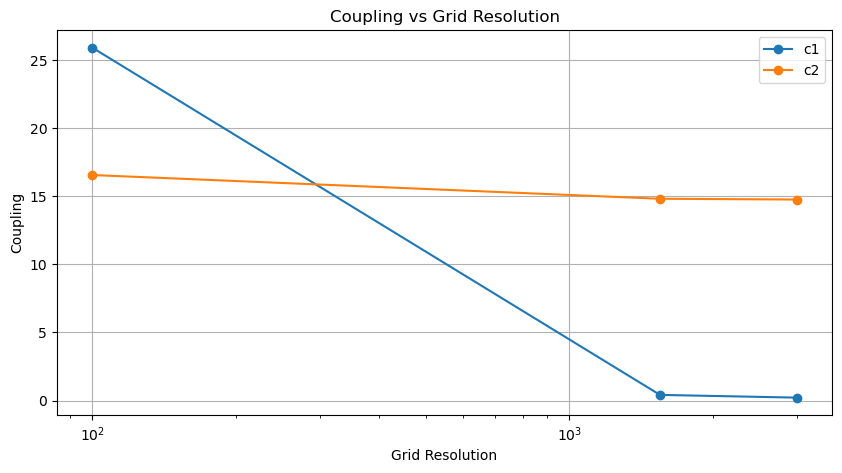

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(grids, c1s, label='c1', marker='o')
plt.plot(grids, c2s, label='c2', marker='o')
plt.xscale('log')
plt.xlabel('Grid Resolution')
plt.ylabel('Coupling')
plt.title('Coupling vs Grid Resolution')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
grids = np.linspace(500,1000,3)

c1s, c2s = [], []

for grid in grids:
    c1, c2 = coupling(grid_resolution=int(grid), plot=False, **default_values)
    c1s.append(c1)
    c2s.append(c2)


/tmp/ipykernel_43621/2274563893.py:134: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s21_a[idx] = s21[np.where(closeness_array),hdx]
/tmp/ipykernel_43621/2274563893.py:146: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s21_b[idx] = s21[np.where(closeness_array), hdx]


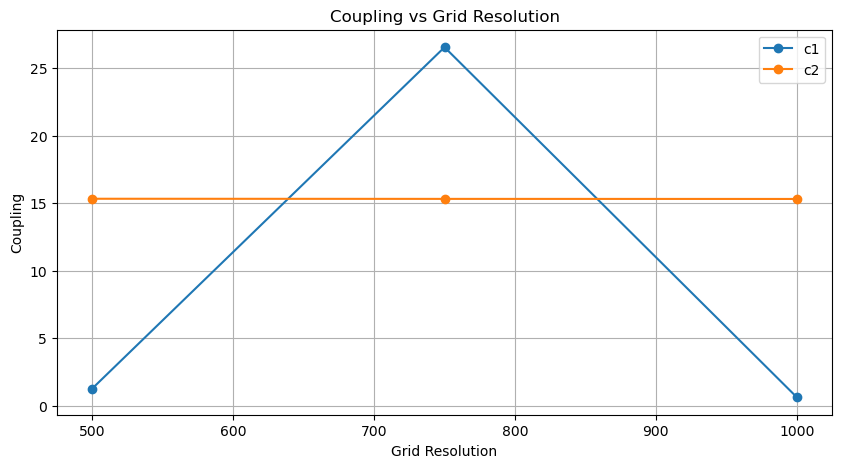

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(grids, c1s, label='c1', marker='o')
plt.plot(grids, c2s, label='c2', marker='o')
# plt.xscale('log')
plt.xlabel('Grid Resolution')
plt.ylabel('Coupling')
plt.title('Coupling vs Grid Resolution')
plt.legend()
plt.grid(True)
plt.show()

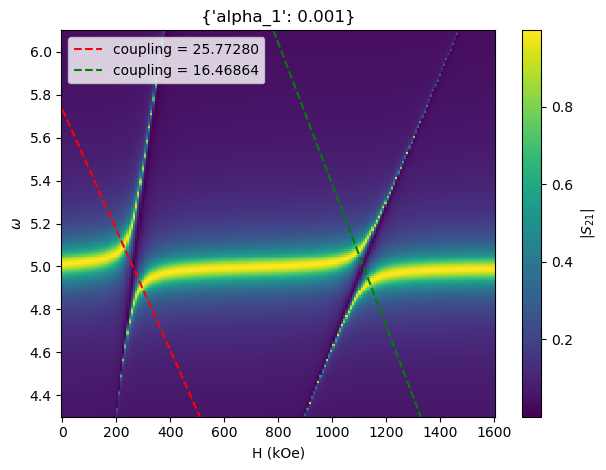

(np.float64(25.77280069664557), np.float64(16.468639068927672))

In [7]:
from revisions import coupling

coupling(alpha_1=1e-3)